In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from lightgbm import LGBMRegressor
import lightgbm as lgb
from statsmodels.tsa.arima.model import ARIMA



Compare four models on the lynx Time Series (you can find it [here](https://alkaline-ml.com/pmdarima/_modules/pmdarima/datasets/lynx.html)):


*   Exponential Smoothing
*   (S)ARIMA(X)
*   Machine Learning Model (LGBM)
*   Deep Learning Model (LSTM)

**1.Keep the last 25% of the Time Series for testing and use the remainder to train and validate.**<br>
**2.Try to optimize these models as much as possible.**<br>
**3.Find the best model.**

# Exponential Smoothing

In [51]:
df_default = pd.read_csv("bitcoin_hourly.csv", parse_dates = ["unix"], index_col=['unix'] )
df_default.index = pd.to_datetime(df_default.index,unit = 's')
df = df_default["close"]
df = df["2022-12-29":"2023-01-29" ].sort_index()
df




unix
2022-12-29 00:00:00    16587.0
2022-12-29 01:00:00    16583.0
2022-12-29 02:00:00    16494.0
2022-12-29 03:00:00    16551.0
2022-12-29 04:00:00    16551.0
                        ...   
2023-01-27 20:00:00    23218.0
2023-01-27 21:00:00    23188.0
2023-01-27 22:00:00    23041.0
2023-01-27 23:00:00    23057.0
2023-01-28 00:00:00    23057.0
Name: close, Length: 730, dtype: float64

In [5]:
def hlco_ratio(df): 
    return (df['high'] - df['low'])/(df['close']-df['open'])
def upper_shadow(df):
    return df['high'] - np.maximum(df['close'], df['open'])
def lower_shadow(df):
    return np.minimum(df['close'], df['open']) - df['low']

def get_features(df):
    df_feat = df.drop(["date", "symbol"], axis=1)
    df_feat['Upper_Shadow'] = upper_shadow(df_feat)
    df_feat['hlco_ratio'] = hlco_ratio(df_feat)
    df_feat['Lower_Shadow'] = lower_shadow(df_feat)
    return df_feat

In [6]:

def get_Xy(df_proc):
    
    df_proc = get_features(df)
    df_proc['y'] = df['close']
    df_proc.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_proc = df_proc.dropna(how="any")
    
    X = df_proc.drop("y", axis=1)
    y = df_proc["y"]   
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle= False)
    X_train.drop("close",axis=1, inplace=True)
    X_test.drop("close",axis=1, inplace=True)
    
    return X_train, X_test, y_train, y_test

In [60]:

df_default = pd.read_csv("bitcoin_hourly.csv", parse_dates = ["unix"], index_col=['unix'] ).drop(['date', 'symbol'], axis=1)
df_default.index = pd.to_datetime(df_default.index,unit = 's')

def print_transactional_data(df: pd.DataFrame):
    btc_mini= df.iloc[-200:]
    fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, open=btc_mini['open'], high=btc_mini['high'], low=btc_mini['low'], close=btc_mini['close'])])
    fig.update_xaxes(title_text="$")
    fig.update_yaxes(title_text="Index")
    fig.update_layout(title="Bitcoin Price, 200 Last Hours")
    fig.show()
print_transactional_data(df_default)

In [8]:
step = int(0.8*len(df))
btc_train, btc_test = df[:step], df[step:]
btc_train

unix
2022-12-29 00:00:00    16587.0
2022-12-29 01:00:00    16583.0
2022-12-29 02:00:00    16494.0
2022-12-29 03:00:00    16551.0
2022-12-29 04:00:00    16551.0
                        ...   
2023-01-21 18:00:00    23288.0
2023-01-21 19:00:00    23283.0
2023-01-21 20:00:00    23145.0
2023-01-21 21:00:00    23183.0
2023-01-21 22:00:00    22814.0
Name: close, Length: 584, dtype: float64

In [9]:
btc_test = btc_test.asfreq("H")
btc_train = btc_train[~btc_train.index.duplicated(keep='first')]
btc_train = btc_train.asfreq("H").dropna()
print(btc_train.isnull().sum())


0


In [10]:
# Not the best way to do it but it works :) 
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

trends = ['add', 'mul']
seasonals = [None, 'add', 'mul']
dampings = [True, False]
methods = ['estimated', 'heuristic']
# Define the best hyperparameters
best_params = {'trend': None, 'seasonal': None, 'damping': None, 'rmse': float('inf'), "seasonal_pedriod": int()}
best_seasonal_periods = [24, 7 ]
# Loop through the hyperparameters
for trend in trends:
    for seasonal in seasonals:
        for damping in dampings:
            for method in methods: 
                for seasonal_period in best_seasonal_periods: 
                # Fit the model
                    s_exp = ExponentialSmoothing(btc_train,
                                    trend=trend,
                                    damped_trend=damping,
                                    seasonal=seasonal,
                                    initialization_method= method, 
                                    seasonal_periods=seasonal_period) 
                    fit = s_exp.fit()

                    # Make predictions
                    y_pred = fit.forecast(steps=len(btc_test))

                    # Calculate the RMSE
                    rmse = np.sqrt(mean_squared_error(btc_test, y_pred))

                    # Update the best hyperparameters
                    if rmse < best_params['rmse']:
                        best_params = {'trend': trend, 'seasonal': seasonal, 'damping': damping, 'rmse': rmse, "seasonal_period": seasonal_period, "method": method}

# Print the best hyperparameters
print("Best hyperparameters: ", best_params)



/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: 

Best hyperparameters:  {'trend': 'add', 'seasonal': 'mul', 'damping': False, 'rmse': 182.37923646670492, 'seasonal_period': 24, 'method': 'estimated'}


/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



In [11]:
from datetime import datetime, timedelta

start_time = datetime.strptime("2023-01-21 23:00:00", "%Y-%m-%d %H:%M:%S")
end_time = start_time + timedelta(days=6.05)
current_time = start_time

hourly_data = []
while current_time < end_time:
    hourly_data.append(current_time.strftime("%Y-%m-%d %H:%M:%S"))
    current_time += timedelta(hours=1)

print(len(hourly_data))

146


In [12]:
s_exp = ExponentialSmoothing(btc_train,
                                trend='add',
                                damped_trend=True,
                                seasonal='add',
                                initialization_method= "estimated", 
                                seasonal_periods=24) 
fit = s_exp.fit()
y_pred = fit.forecast(steps=len(btc_test))

                # Calculate the RMSE
# rmse = np.sqrt(mean_squared_error(btc_test, y_pred))
predictions_df =pd.DataFrame(data=y_pred, index=pd.to_datetime(hourly_data), columns=['close'])




/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



In [13]:
predictions_df["close"] = y_pred.values
predictions_df

,close
2023-01-21 23:00:00,22876.666811
2023-01-22 00:00:00,22914.742106
2023-01-22 01:00:00,22911.688141
2023-01-22 02:00:00,22943.258961
2023-01-22 03:00:00,22929.330891
...,...
2023-01-27 20:00:00,23917.447973
2023-01-27 21:00:00,23901.475158
2023-01-27 22:00:00,23875.546594
2023-01-27 23:00:00,23884.149037


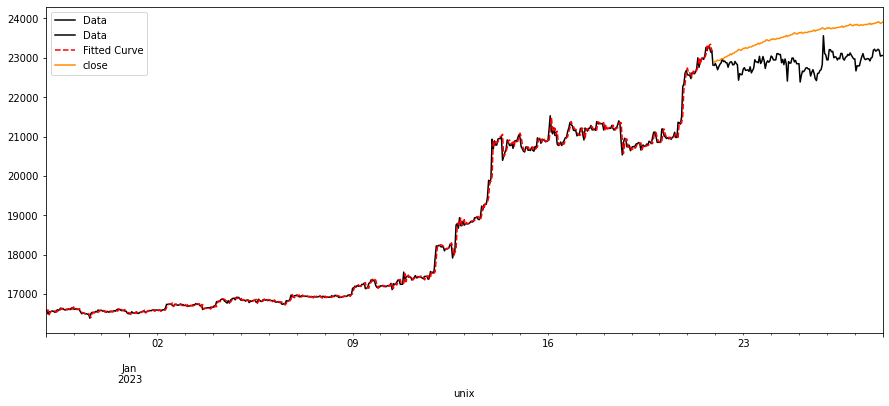

In [14]:
fig, ax = plt.subplots(figsize=(15,6))
btc_test.plot(ax=ax, color='black', label='Data')
btc_train.plot(ax=ax, color='black', label='Data')
fit.fittedvalues.plot(ax=ax, color='red', linestyle='--', label='Fitted Curve')
predictions_df.plot(ax=ax, color='darkorange', label='Prediction')
plt.legend()
plt.show()


In [15]:
rmse = np.sqrt(mean_squared_error(btc_test, y_pred))
print(f'RMSE: {rmse:.4f}')
print(f'AIC: {fit.aic:.4f}')
print(f'BIC: {fit.bic:.4f}')

RMSE: 712.8916
AIC: 5432.1315
BIC: 5558.4082


# Arima

In [16]:
from statsmodels.tsa.stattools import adfuller, kpss


def test_stationarity(df, **kwargs):
    ## ADFuller
    adf_result = adfuller(df, **kwargs)

    if adf_result[1] < 0.05: adf_decision = 'Stationary'
    else : adf_decision = 'Non-Stationary'

    adf_dict = {'decision': adf_decision,
                'Test Statistic': adf_result[0],
                'p-value': adf_result[1],
                'Numbers of lags': adf_result[2]}
    
    for key, value in adf_result[4].items():
        adf_dict[f"Critical Value {key}"] = value
    
    ## KPSS
    kpss_result = kpss(df, **kwargs)
    
    if kpss_result[1] > 0.05: kpss_decision = 'Stationary'
    else : kpss_decision = 'Non-Stationary'

    kpss_dict = {'Decision': kpss_decision,
                 'Test Statistic': kpss_result[0],
                 'p-value': kpss_result[1],
                 'Numbers of lags': kpss_result[2]}

    for key, value in kpss_result[3].items():
        if key != "2.5%" :
            kpss_dict[f"Critical Value {key}"] = value

    df = pd.DataFrame(adf_dict.values(), columns=['ADF'], index=adf_dict.keys())
    df['KPSS'] = kpss_dict.values()
    return df

In [17]:
test_stationarity(btc_train)

/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




,ADF,KPSS
decision,Non-Stationary,Non-Stationary
Test Statistic,0.973613,2.654789
p-value,0.99398,0.01
Numbers of lags,1,19
Critical Value 1%,-3.441814,0.347
Critical Value 5%,-2.866597,0.463
Critical Value 10%,-2.569463,0.739


In [18]:
btc_diff = btc_train.diff(1).dropna()
test_stationarity(btc_diff)

/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




,ADF,KPSS
decision,Stationary,Stationary
Test Statistic,-25.365663,0.346559
p-value,0.0,0.1
Numbers of lags,0,19
Critical Value 1%,-3.441814,0.347
Critical Value 5%,-2.866597,0.463
Critical Value 10%,-2.569463,0.739


/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



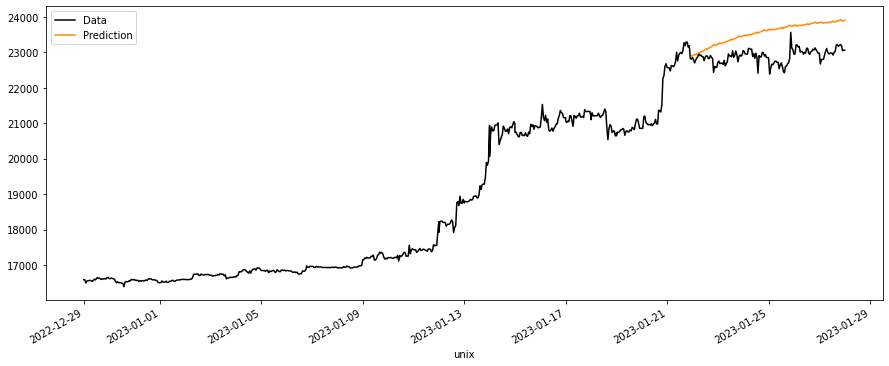

In [19]:
# Predictions
y_pred = fit.forecast(len(btc_test))
y_pred.index = btc_test.index

fig, ax = plt.subplots(figsize=(15,6))
df.plot(ax=ax, color='black', label='Data')
y_pred.plot(ax=ax, color='darkorange', label='Prediction')
plt.legend()
plt.show()

In [20]:
from itertools import product
import warnings

def find_best_arima(data, max_p, max_q, max_d, exog : None):
    best_params = {'p': None, 'd': None, 'q': None}
    comb = product(*[range(max_p+1), range(max_d+1), range(max_q+1)])
    aicc = np.inf
    for (p,d,q) in comb:
        
        if p == q == 0 : continue
        arima = ARIMA(data,
                      order=(p,d,q), exog = exog)  
        fit2 = arima.fit()
        rmse = np.sqrt(mean_squared_error(btc_test, y_pred))

        if aicc > fit2.aicc :
            aicc = fit2.aicc
            best_model = arima
            best_fit = fit2
            best_params = {'p': p, 'd': d, 'q': q }
    print(best_params)
    return best_model, best_fit

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model, fitted= find_best_arima(btc_diff, 3,3,3,exog=None)
    
fitted.summary()

{'p': 3, 'd': 1, 'q': 3}


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                  574
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -3494.998
Date:                Thu, 02 Feb 2023   AIC                           7003.997
Time:                        21:52:45   BIC                           7034.453
Sample:                    12-29-2022   HQIC                          7015.877
                         - 01-21-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6834      0.034    -48.818      0.000      -1.751      -1.616
ar.L2         -1.1049      0.052    -21.149      0.000      -1.207      -1.002
ar.L3         -0.0744      0.032     -2.315      0.021      -0.137      -0.011
ma.L1          0.6396      0.073      8.738      0.000       0.496       0.783
ma.L2         -0.6419      0.077     -8.303      0.000      -0.793      -0.490
ma.L3         -0.9977      0.022    -44.953      0.000      -1.041      -0.954
sigma2      1.141e+04   1.78e-05   6.41e+08      0.000    1.14e+04    1.14e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             10034.16
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):              28.44   Skew:                             1.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.44e+23. Standard errors may be unstable.
"""

/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



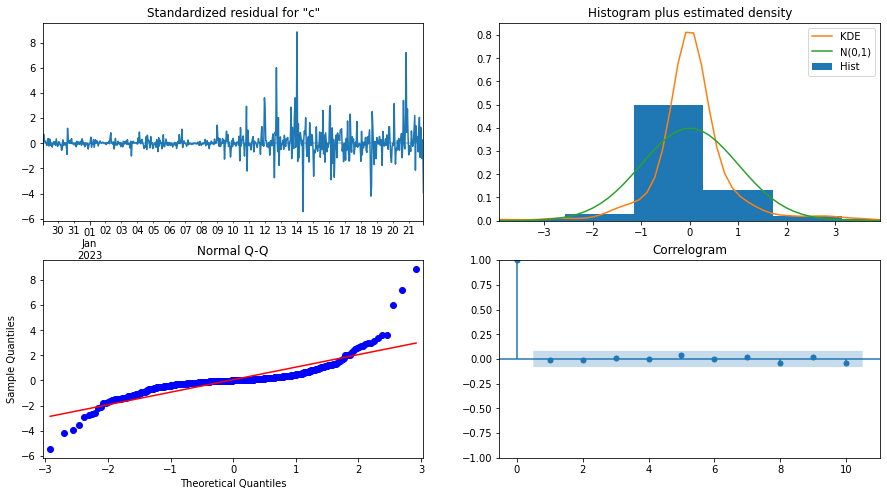

In [21]:
g = fitted.plot_diagnostics(figsize=(15,8))
plt.show()

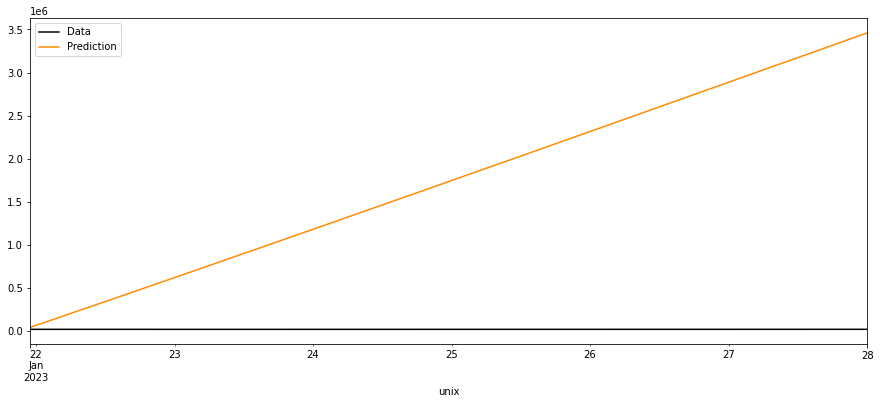

In [22]:
# Predictions
redone = y_pred.cumsum().add(btc_test[0])
y_pred = fitted.forecast(len(btc_test))
y_pred.index = btc_test.index

fig, ax = plt.subplots(figsize=(15,6))
btc_test.plot(ax=ax, color='black', label='Data')
redone.plot(ax=ax, color='darkorange', label='Prediction')
plt.legend()
plt.show()

In [23]:
rmse = np.sqrt(mean_squared_error(btc_test, y_pred))
rmse

22877.059810565956

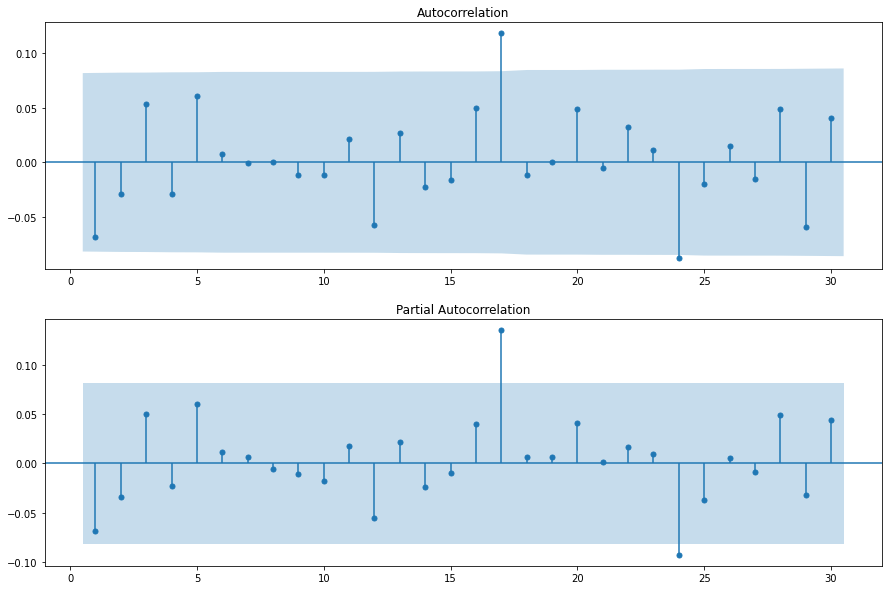

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(2,1,figsize=(15,10))
g1 = plot_acf(btc_diff, zero=False, lags=30, ax=axs[0])
g2 = plot_pacf(btc_diff, zero=False, lags=30, ax=axs[1], method='ywm')
plt.show()

# LGBM On close price 

In [25]:
# !pip install lightgbm

In [26]:
df = pd.read_csv("bitcoin_hourly.csv", usecols = ['unix','close'], parse_dates = ["unix"])
df['unix'] = pd.to_datetime(df['unix'],unit = 's')
df = df.set_index('unix')
df = df["close"]
df = df["2022-12-29":"2023-01-29"].sort_index()
step = int(0.8*len(df))
train_df, test_df = df[:step], df[step:]

x_train = train_df.drop(train_df.index[-1]).values.reshape(-1,1)
x_test = test_df.drop(test_df.index[-1]).values.reshape(-1,1)

y_train = train_df[1:].values.reshape(-1,1).ravel()
y_test = test_df[1:].values.reshape(-1,1).ravel()


In [27]:


# Train the LGBM model
# Define the hyperparameter search space
# param_grid = {
#  'max_depth': range (2, 10, 1),
#     'num_leaves': range(2, 120, 10),
#     'learning_rate': [0.1, 0.01, 0.05, 0.001]
# }

# # Define the LGBM model
# lgbm = lgb.LGBMRegressor()

# # Use GridSearchCV to perform hyperparameter tuning
# grid_search = GridSearchCV(lgbm, param_grid,
#         cv = 5,
#         verbose=True)

# grid_search.fit(x_train, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# print("Best Hyperparameters: ", best_params)
best_params = {'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 22}
# Train the LGBM model with the best hyperparameters
lgbm = lgb.LGBMRegressor(**best_params)
lgbm.fit(x_train, y_train)

# Predict on the test set
y_pred = lgbm.predict(x_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 33267.90


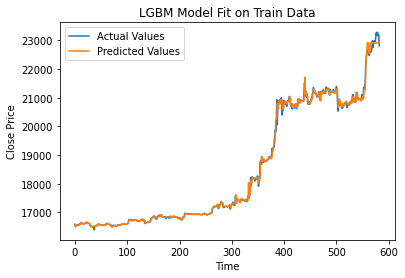

In [28]:
import matplotlib.pyplot as plt

# Get the predictions from the LGBM model on the train data
train_predictions = lgbm.predict(x_train)

# Plot the train predictions and actual values
plt.plot(y_train, label='Actual Values')
plt.plot(train_predictions, label='Predicted Values')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('LGBM Model Fit on Train Data')
plt.show()

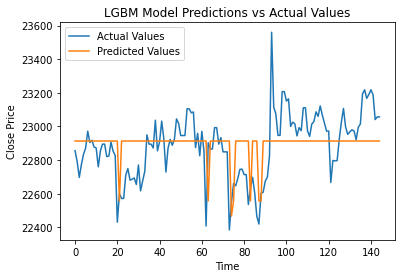

In [29]:
import matplotlib.pyplot as plt

# Get the predictions from the LGBM model
predictions = lgbm.predict(x_test)

# Plot the predictions and actual values
plt.plot(y_test, label='Actual Values')
plt.plot(predictions, label='Predicted Values')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('LGBM Model Predictions vs Actual Values')
plt.show()

# Better LGBM with more params for training and predictins. 

In [30]:
df = pd.read_csv("bitcoin_hourly.csv", parse_dates = ["unix"])
df['unix'] = pd.to_datetime(df['unix'],unit = 's')
df

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDC
0,2023-01-28 00:00:00,2023-01-28 00:00:00,BTC/USDC,23057.00,23057.00,23057.00,23057.00,0.000000,0.000000
1,2023-01-27 23:00:00,2023-01-27 23:00:00,BTC/USDC,23054.00,23057.00,23054.00,23057.00,0.010847,250.099279
2,2023-01-27 22:00:00,2023-01-27 22:00:00,BTC/USDC,23041.00,23041.00,23041.00,23041.00,0.001734,39.953094
3,2023-01-27 21:00:00,2023-01-27 21:00:00,BTC/USDC,23188.00,23188.00,23188.00,23188.00,0.000595,13.796860
4,2023-01-27 20:00:00,2023-01-27 20:00:00,BTC/USDC,23257.00,23258.00,23218.00,23218.00,0.014143,328.380997
...,...,...,...,...,...,...,...,...,...
7232,2022-04-02 01:00:00,2022-04-02 01:00:00,BTC/USDC,46980.34,47036.00,46533.88,46751.88,0.828719,38744.160956
7233,2022-04-02 00:00:00,2022-04-02 00:00:00,BTC/USDC,46225.31,47128.00,46225.31,46939.00,0.346731,16275.203123
7234,2022-04-01 23:00:00,2022-04-01 23:00:00,BTC/USDC,46340.52,46340.52,46189.00,46189.00,0.011892,549.279588
7235,2022-04-01 22:00:00,2022-04-01 22:00:00,BTC/USDC,46368.97,46374.00,46189.00,46374.00,0.008949,415.000926


In [31]:

df = pd.read_csv("bitcoin_hourly.csv", parse_dates = ["unix"])
df['unix'] = pd.to_datetime(df['unix'],unit = 's')
df = df.set_index('unix')
df = df.sort_index()
# df.drop(['date'], inplace = True)
btc_mini= df.iloc[-200:]
fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, open=btc_mini['open'], high=btc_mini['high'], low=btc_mini['low'], close=btc_mini['close'])])
fig.update_xaxes(title_text="$")
fig.update_yaxes(title_text="Index")
fig.update_layout(title="Bitcoin Price, 200 Last Hours")
fig.show()


In [32]:
X_train, X_test, y_train, y_test = get_Xy(df)

/var/folders/60/bfzc0kqx1l54g6mx713k6cx80000gn/T/ipykernel_59836/3827500574.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/60/bfzc0kqx1l54g6mx713k6cx80000gn/T/ipykernel_59836/3827500574.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
def lgbm_train(X_train, y_train, X_test, y_test):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }
    gbm = lgb.train(params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['train','valid'],
        # callbacks=[lgb.early_stopping(stopping_rounds=100)]
        )
    return gbm


In [34]:
gbm = lgbm_train(X_train, y_train, X_test,y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[1]	train's l1: 6031.01	train's l2: 5.35374e+07	valid's l1: 6995.72	valid's l2: 5.32161e+07
[2]	train's l1: 5729.55	train's l2: 4.83208e+07	valid's l1: 6646.03	valid's l2: 4.80296e+07
[3]	train's l1: 5443.25	train's l2: 4.36147e+07	valid's l1: 6315.59	valid's l2: 4.33739e+07
[4]	train's l1: 5171.28	train's l2: 3.93666e+07	valid's l1: 6002.44	valid's l2: 3.91815e+07
[5]	train's l1: 4912.97	train's l2: 3.55339e+07	valid's l1: 5704.77	valid's l2: 3.53979e+07
[6]	train's l1: 4667.51	train's l2: 3.20736e+07	valid's l1: 5421.76	valid's l2: 3.19755e+07
[7]	train's l1: 4434.35	train's l2: 2.89498e+07	valid's l1: 5150.31	valid's l2: 2.88597e+07
[8]	train's l1: 4212.85	train's

In [35]:
predictions = gbm.predict(X_test)


In [36]:
pred = pd.DataFrame(predictions)
pred.index = X_test.index

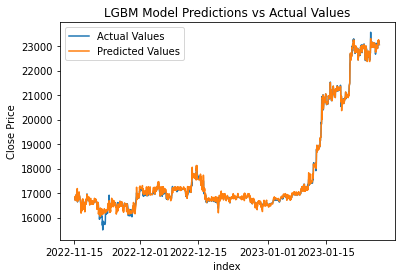

In [37]:

import matplotlib.pyplot as plt

# Get the predictions from the LGBM model

# Plot the predictions and actual values
plt.plot(y_test, label='Actual Values')
plt.plot(pred, label='Predicted Values')
plt.legend()
plt.xlabel('index')
plt.ylabel('Close Price')
plt.title('LGBM Model Predictions vs Actual Values')
plt.show()


In [38]:
rmse_test = mean_squared_error(y_test, pred)
rmse_test

9972.087621986735

## I've read in an article that is better to use a longer DF for LGBM so i will try to make prediction on xrp/usd

In [39]:
df = pd.read_csv("xrp_usd.csv")
# df['unix'] = pd.to_datetime(df['unix'],unit = 's')
# df = df.drop("unix", axis = 1)
# df = df.set_index('date')
df['unix'] = pd.to_datetime(df['unix'],unit = 's')
df = df.set_index('unix')
df = df.sort_index()
xrp_mini= df.iloc[-200:]
fig = go.Figure(data=[go.Candlestick(x=xrp_mini.index, open=xrp_mini['open'], high=xrp_mini['high'], low=xrp_mini['low'], close=xrp_mini['close'])])
fig.update_xaxes(title_text="$")
fig.update_yaxes(title_text="Index")
fig.update_layout(title="XRP Price, 200 Last Hours")
fig.show()

In [40]:
X_train, X_test, y_train, y_test = get_Xy(df)

/var/folders/60/bfzc0kqx1l54g6mx713k6cx80000gn/T/ipykernel_59836/3827500574.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/60/bfzc0kqx1l54g6mx713k6cx80000gn/T/ipykernel_59836/3827500574.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
gbm = lgbm_train(X_train, y_train, X_test, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[1]	train's l1: 0.236613	train's l2: 0.0923061	valid's l1: 0.128148	valid's l2: 0.0230734
[2]	train's l1: 0.224791	train's l2: 0.0833226	valid's l1: 0.121606	valid's l2: 0.0208042
[3]	train's l1: 0.213567	train's l2: 0.0752162	valid's l1: 0.115443	valid's l2: 0.0187654
[4]	train's l1: 0.202897	train's l2: 0.067896	valid's l1: 0.109601	valid's l2: 0.016923
[5]	train's l1: 0.192761	train's l2: 0.0612923	valid's l1: 0.104032	valid's l2: 0.0152613
[6]	train's l1: 0.183133	train's l2: 0.0553278	valid's l1: 0.0987927	valid's l2: 0.0137662
[7]	train's l1: 0.173981	train's l2: 0.0499449	valid's l1: 0.0937646	valid's l2: 0.0124196
[8]	train's l1: 0.165291	train's l2: 0.045085

In [42]:
predictions = gbm.predict(X_test)
predictions = pd.DataFrame(predictions)
predictions.index = X_test.index

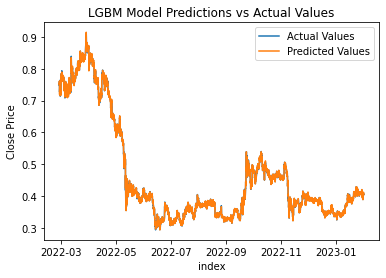

In [43]:
import matplotlib.pyplot as plt

# Get the predictions from the LGBM model

# Plot the predictions and actual values
plt.plot(y_test, label='Actual Values')
plt.plot(predictions, label='Predicted Values')
plt.legend()
plt.xlabel('index')
plt.ylabel('Close Price')
plt.title('LGBM Model Predictions vs Actual Values')
plt.show()

In [44]:
X_test

,open,high,low,Volume XRP,Volume USD,Upper_Shadow,hlco_ratio,Lower_Shadow
unix,,,,,,,,
2022-02-26 17:00:00,0.74671,0.75297,0.74528,2.168501e+05,162993.175837,0.00133,1.559838,0.00143
2022-02-26 18:00:00,0.75087,0.75147,0.74123,5.924020e+05,442873.808741,0.00060,-3.121951,0.00636
2022-02-26 19:00:00,0.74792,0.75651,0.74792,4.010400e+05,302047.313309,0.00335,1.639313,0.00000
2022-02-26 20:00:00,0.75369,0.76196,0.75258,3.131813e+05,237754.696444,0.00280,1.714808,0.00111
2022-02-26 21:00:00,0.75699,0.76473,0.75698,4.393900e+05,334050.632823,0.00447,2.370031,0.00001
...,...,...,...,...,...,...,...,...
2023-01-31 20:00:00,0.40986,0.41129,0.40678,1.499752e+06,611043.911480,0.00143,-1.855967,0.00065
2023-01-31 21:00:00,0.40733,0.40799,0.40219,2.307049e+06,933455.175894,0.00066,-2.132353,0.00242
2023-01-31 22:00:00,0.40511,0.40942,0.40369,1.058857e+06,431177.302375,0.00221,2.728571,0.00142


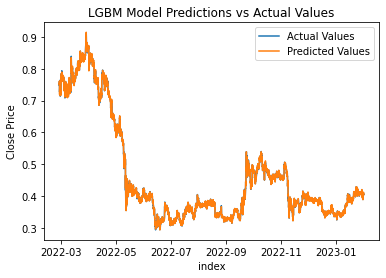

In [45]:
plt.plot(y_test, label='Actual Values')
plt.plot(predictions, label='Predicted Values')
plt.legend()
plt.xlabel('index')
plt.ylabel('Close Price')
plt.title('LGBM Model Predictions vs Actual Values')
plt.show()

In [61]:
rmse_test = mean_squared_error(y_test, predictions)
rmse_test

2.0920056498018167e-06

# LSTM

In [65]:
df_default.columns


Index(['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USDC'], dtype='object')

In [197]:
import numpy as np
import pandas as pd
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf
# Load the data into a dataframe

# Select the columns of interest

# Split the data into training and testing sets
train_data = df_default.iloc[:5000, :]["close"].values.reshape(-1, 1)
test_data = df_default.iloc[5000:, :]["close"].values.reshape(-1, 1)

# Scale the training data for better results
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

# Define the input and output features for the LSTM model
X_train = scaled_train_data[:, :-1]
y_train = scaled_train_data[:, -1]
X_test = scaled_test_data[:, :-1]
y_test = scaled_test_data[:, -1]

# Reshape the input data to match the format required by the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the LSTM model
model.compile(optimizer='adam', loss='mean_squared_error')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
# Train the LSTM model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=256,
    shuffle=False,
    validation_split=0.1,
    callbacks=[callback]
)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Inverse the scaling on the predictions to get the original values
y_pred = scaler.inverse_transform(y_pred)

Epoch 1/10
18/18 [==============================] - 5s 55ms/step - loss: 0.1757 - val_loss: 0.2051
Epoch 2/10
18/18 [==============================] - 0s 9ms/step - loss: 0.0720 - val_loss: 0.0631
Epoch 3/10
18/18 [==============================] - 0s 9ms/step - loss: 0.0686 - val_loss: 0.0436
Epoch 4/10
18/18 [==============================] - 0s 9ms/step - loss: 0.0735 - val_loss: 0.0531
Epoch 5/10
18/18 [==============================] - 0s 9ms/step - loss: 0.0699 - val_loss: 0.0556
Epoch 6/10
18/18 [==============================] - 0s 8ms/step - loss: 0.0690 - val_loss: 0.0541
Epoch 7/10
18/18 [==============================] - 0s 8ms/step - loss: 0.0693 - val_loss: 0.0535
Epoch 8/10
18/18 [==============================] - 0s 11ms/step - loss: 0.0694 - val_loss: 0.0537
Epoch 9/10
18/18 [==============================] - 0s 8ms/step - loss: 0.0693 - val_loss: 0.0537
Epoch 10/10
70/70 [==============================] - 1s 2ms/step


In [198]:
# y_pred = y_pred.reshape(-1, 1)
# 
# y_pred = scaler.inverse_transform(y_pred)

In [199]:
# pred_data = pd.DataFrame(y_pred, index=test_data.index, columns=test_data.columns)
pred_data.shape

(2237, 6)

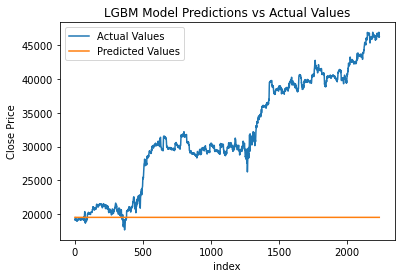

In [205]:
pred_data = pd.DataFrame(y_pred, columns=['close'])


# pred_data.plot()
plt.plot(test_data, label='Actual Values')
plt.plot(pred_data, label='Predicted Values')
plt.legend()
plt.xlabel('index')
plt.ylabel('Close Price')
plt.title('LGBM Model Predictions vs Actual Values')
plt.show()

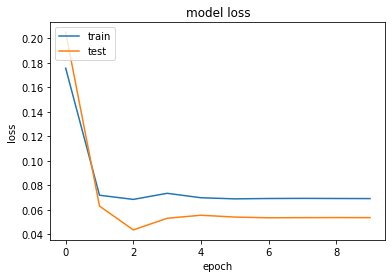

In [206]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()